## Import

In [77]:
import os
import gurobipy as gp
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import DataLoader
from utils.EnergyDataset import EnergyDataset
from utils.utils import calcBatteryCapacity

## Parameter

In [78]:
# Parameters
output_dir = '../outputs/baseline/'
filename = 'sliding_window'
households = range(1,11)

## Sliding Window Approach

In [79]:
def sliding_window(func):
    solution_aggregated = {}
    cost_aggregated = []
    for household in households:
        # Prepare data
        ds = EnergyDataset('../data/Final_Energy_dataset.csv','../data/price.csv', 48, household, 'test', True)
        dl = iter(DataLoader(dataset=ds, batch_size=1, shuffle=False, num_workers=0))
        battery_capacity = calcBatteryCapacity(ds).item()
        battery_power = battery_capacity / 4
        old_soe = 0.0

        # Prepare LP model 
        timeslot = range(0, 48, 1)
        LP = gp.Model('bess_opti')
        LP.setParam('OutputFlag', 0)
        final_cost = torch.tensor(0.0)
        priceFull = []
        
        solution_actions = []
        solution_soe = []
        
        for _ in range(364):
            load, price, _ = func(dl, household)
            load = load.flatten().numpy()
            price = price.flatten().numpy()
            priceFull.append(price)
            action = LP.addVars(timeslot, lb=-battery_power, ub=battery_power, vtype=gp.GRB.CONTINUOUS, name="action")
            soe = LP.addVars(range(0, 49, 1), vtype=gp.GRB.CONTINUOUS, name="soe")

            # Initial SOE constraint
            LP.addConstr(soe[0] == old_soe, "Initial_SOE")
            
            # Define SOE constraints over time
            for t in timeslot:
                LP.addConstr(soe[t + 1] == soe[t] + action[t], f"SOE_Update_{t}")
                LP.addConstr(soe[t + 1] >= 0, f"SOE_Lower_Bound_{t}")
                LP.addConstr(soe[t + 1] <= battery_capacity, f"SOE_Upper_Bound_{t}")

            # Define net load and objective function
            cost = gp.quicksum(price[t] * (load[t] + action[t]) for t in timeslot)
            LP.setObjective(cost, gp.GRB.MINIMIZE)
            
            # Optimize model
            LP.optimize()

            old_soe = soe[48].x
            optimal_actions = [action[t].x for t in timeslot]
            final_objective_value = sum(price[t] * (load[t] + optimal_actions[t]) for t in timeslot)
            final_cost += final_objective_value

            solution_actions.extend([action[t].x for t in timeslot])
            solution_soe.extend([soe[t].x for t in timeslot])
        
        dataframe = pd.DataFrame({
            f"actions": solution_actions,
            f"soe": solution_soe
        })
        cost_aggregated.append(final_cost.item())
        solution_aggregated[household] = dataframe
    return (pd.DataFrame(cost_aggregated,index=households,columns=['cost']), solution_aggregated)

In [80]:
def save_dataframes(set, type):
    cost, solution = set
    os.makedirs(output_dir, exist_ok=True)
    cost.to_csv(f"{output_dir}{filename}_{type}_cost.csv", index=False)
    for household in households:
        solution[household].to_csv(f"{output_dir}{filename}_{type}_{household}.csv", index=False)

### Perfect Foresight

In [ ]:
def perfectForesight(dl, household):
    for _ in range(48):
        forecast = next(dl)
    return forecast

In [ ]:
save_dataframes(sliding_window(perfectForesight), 'perfect_foresight')

### Forecast

In [81]:
class Foreacaster(nn.Module):
    def __init__(self, input_shape):
        super(Foreacaster, self).__init__()

        input_size  = 48*3

        self.flatten = nn.Flatten(start_dim=1)
        self.fc1 = nn.Linear(input_size, 64)
        self.dropout = nn.Dropout(0.01)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [85]:
class ForecastPipeline:
    def __init__(self, calc_metric=True):
        self.calc_metric = calc_metric
        self.results = {}
        self.metrics = {}

    def setup(self, household):
        self._dl_train = iter(DataLoader(dataset=EnergyDataset('../data/Final_Energy_dataset.csv','../data/price.csv', 49, household, 'train', True), batch_size=16, shuffle=True, num_workers=0))
        self._dl_test = iter(DataLoader(dataset=EnergyDataset('../data/Final_Energy_dataset.csv','../data/price.csv', 49, household, 'eval', True), batch_size=1, shuffle=False, num_workers=0))
        self.model = Foreacaster(input_shape=(16,48,3))

    def train(self, epochs=100):
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        for epoch in range(epochs):
            self.model.train()
            for load, _, feature in self._dl_train:
                load_input = load[:,:48].unsqueeze(-1)
                load_target = load[:,48:]
                feature_input = feature[:,:48,:]
                input = torch.cat((load_input, feature_input), dim=2)
                target = load_target
                optimizer.zero_grad()
                output = self.model(input)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
        
    def evaluate(self):
        output = []
        target = []
        self.model.eval()
        for load, _, feature in self._dl_test:
            load_input = load[:,:48].unsqueeze(-1)
            load_target = load[:,48:]
            feature_input = feature[:,:48,:]
            input = torch.cat((load_input, feature_input), dim=2)
            target.extend(load_target)
            output.extend(self.model(input).detach())
        return target, output

    def calculate_metrics(self, y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        return {"mse": mse, "rmse": rmse, "mae": mae}
    
    def predict(self, dl, household):
        self.model = Foreacaster(input_shape=(1,48,3))
        self.model.load_state_dict(torch.load(f'../outputs/baseline/forecast_model_{household}.pt'))
        self.model.eval()
        forecast = []
        for _ in range(0,48):
            load, price, feature = next(dl)
            input = torch.cat((load.unsqueeze(-1), feature), dim=2)
            output = self.model(input)
            forecast.append(output.item())
        forecast = torch.tensor(forecast, dtype=torch.float32)
        return forecast, price, feature

    def main(self):
        for household in households:
            self.setup(household)
            self.train(epochs=100)
            y_true, y_pred = self.evaluate()
           
            torch.save(self.model.state_dict(), f'../outputs/baseline/forecast_model_{household}.pt')

            if self.calc_metric:
                metrics = self.calculate_metrics(y_true, y_pred)
                self.results[household] = (y_true, y_pred)
                self.metrics[household] = metrics
                plt.figure(figsize=(12, 5))
                plt.plot(y_true[:200], label='Ground Truth')
                plt.plot(y_pred[:200], label='Prediction', linestyle='dashed')
                plt.xlabel('Timestep')
                plt.ylabel('Value')
                plt.title(f'Ground Truth vs Prediction Household {household} (first 200 samples)')
                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plt.show()

        mse_values = [self.metrics[h]['mse'] for h in households]
        rmse_values = [self.metrics[h]['rmse'] for h in households]
        mae_values = [self.metrics[h]['mae'] for h in households]

        x = np.arange(len(households))  # One bar group per household
        width = 0.25  # Width of each bar

        plt.figure(figsize=(14, 6))
        plt.bar(x - width, mse_values, width, label='MSE')
        plt.bar(x, rmse_values, width, label='RMSE')
        plt.bar(x + width, mae_values, width, label='MAE')

        plt.xlabel('Household')
        plt.ylabel('Error')
        plt.title('Forecasting Metrics per Household')
        plt.xticks(x, households, rotation=45)
        plt.legend()
        plt.grid(axis='y')
        plt.tight_layout()
        plt.show()

In [87]:
pipeline = ForecastPipeline()

In [ ]:
# models = pipeline.main()

In [88]:
save_dataframes(sliding_window(pipeline.predict), 'forecast')

## Visualization

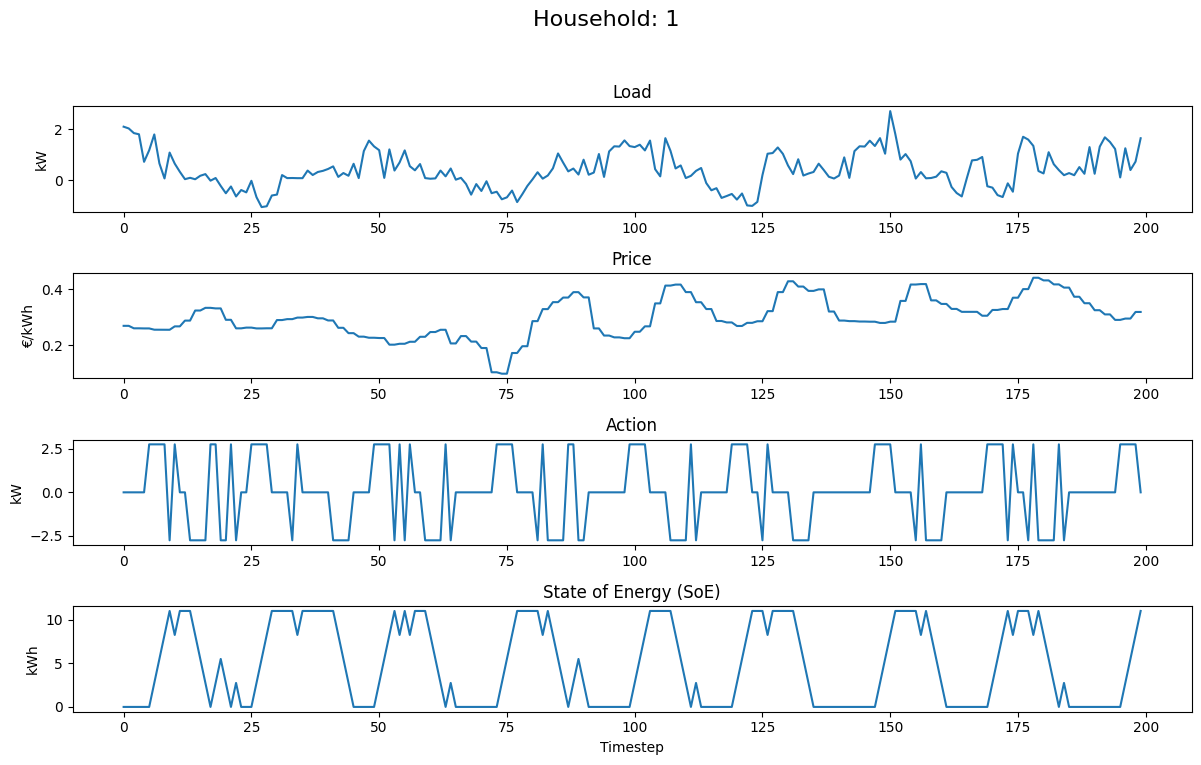

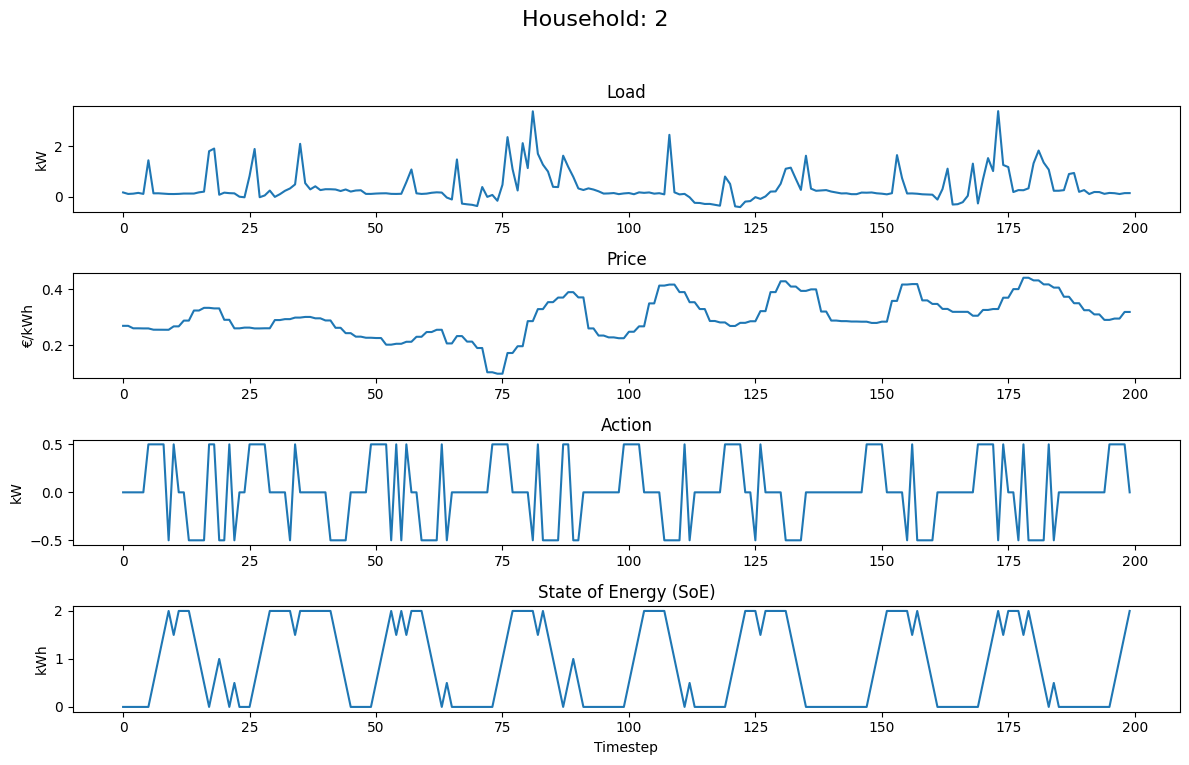

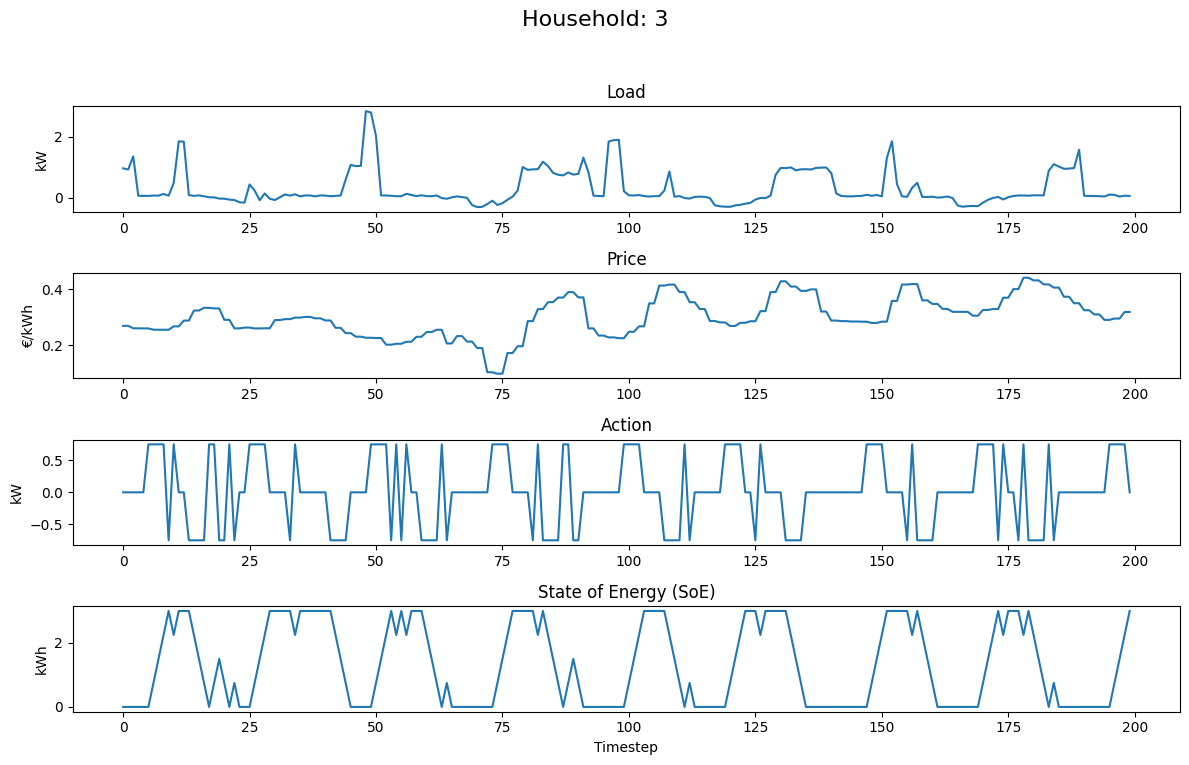

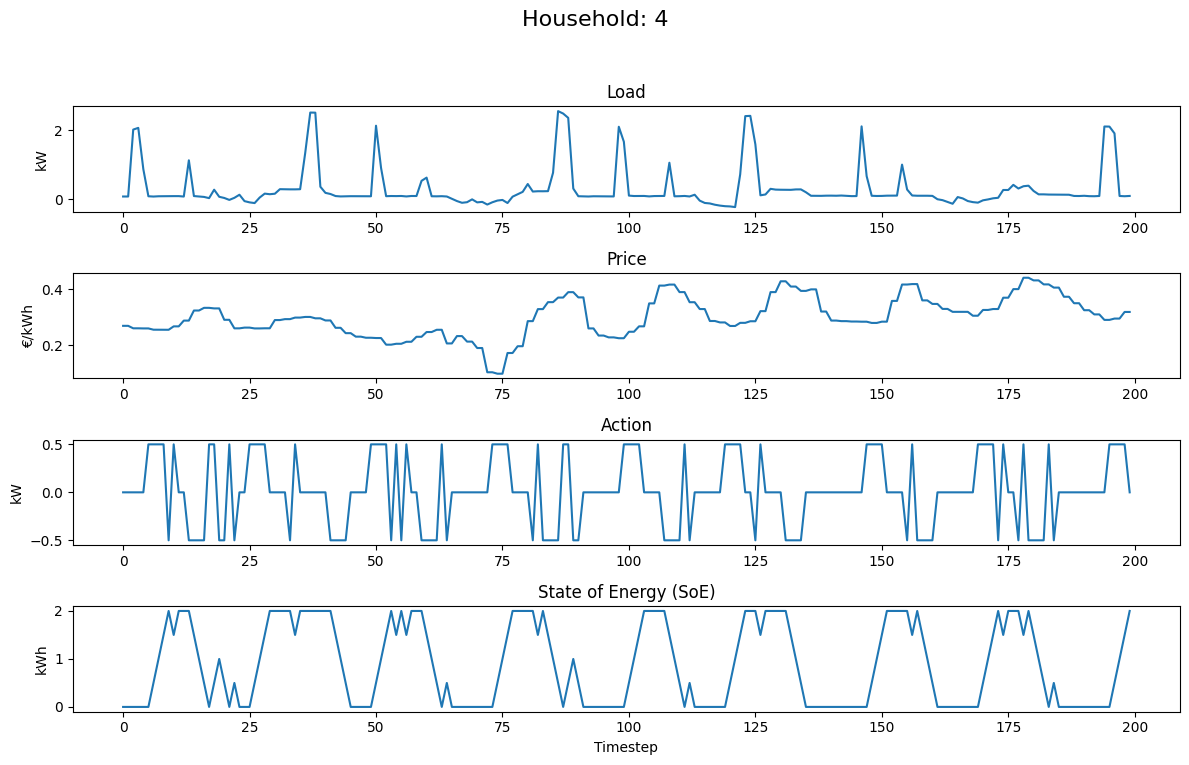

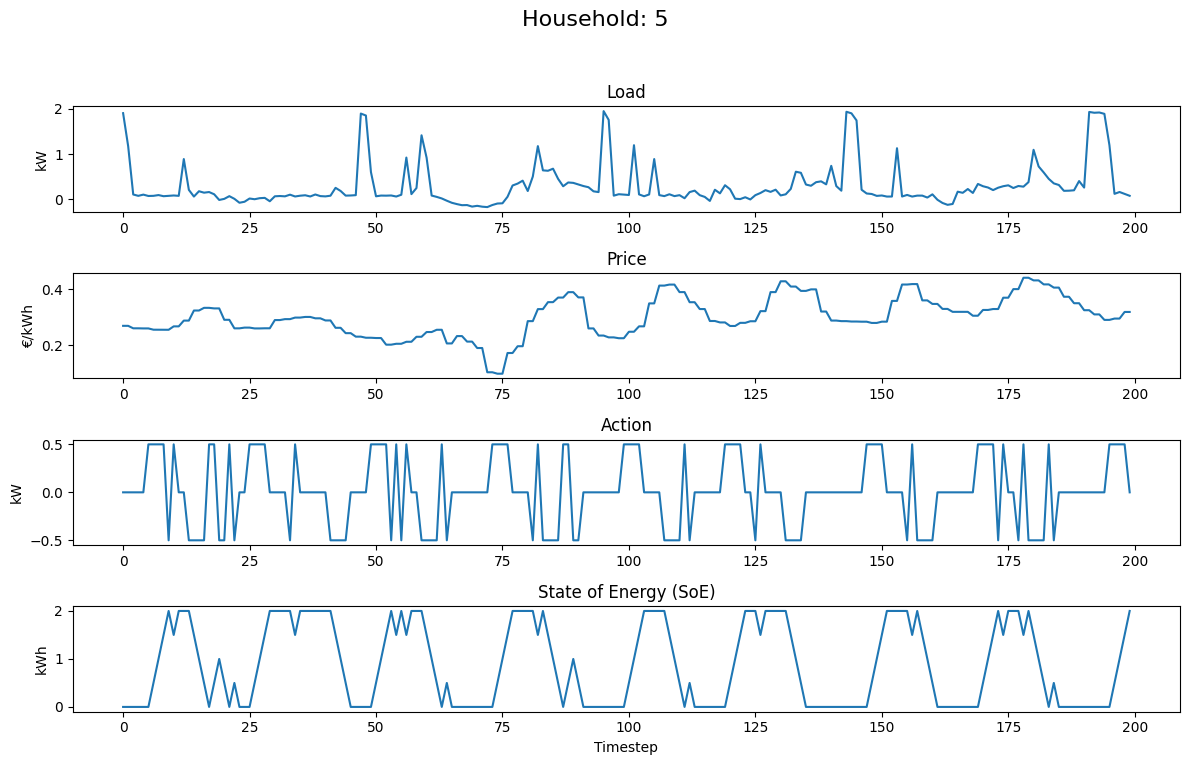

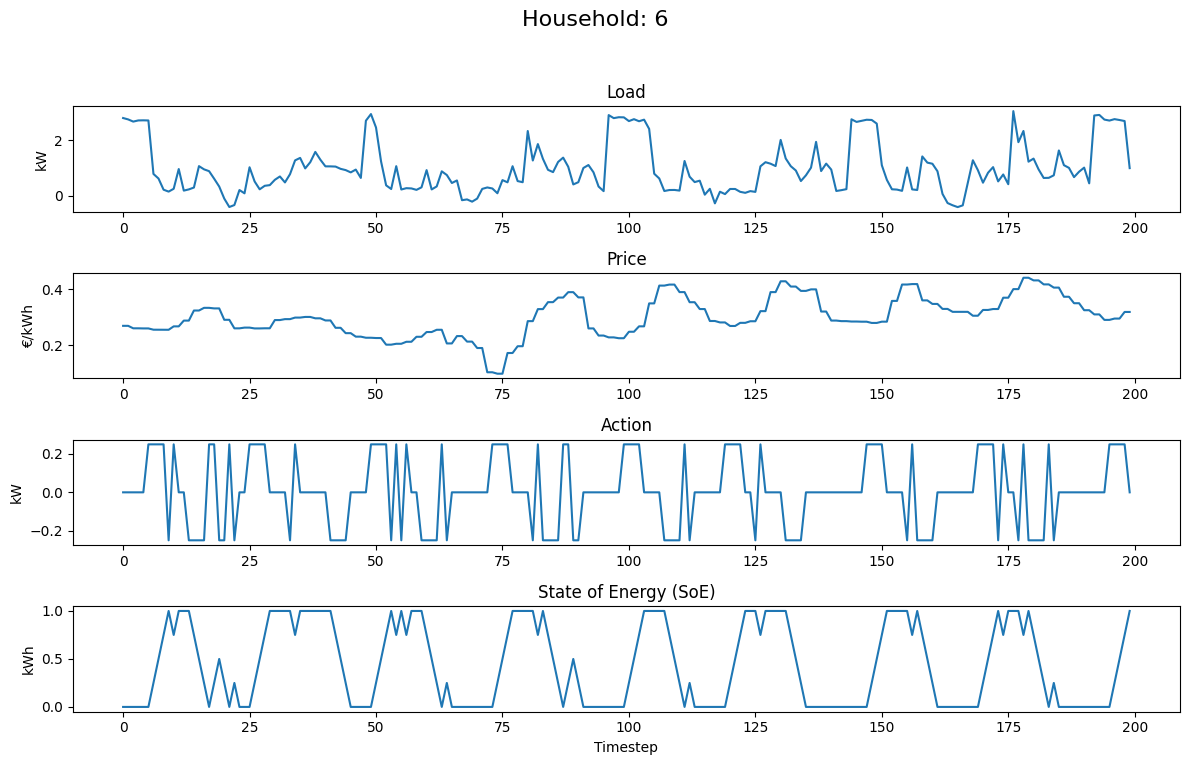

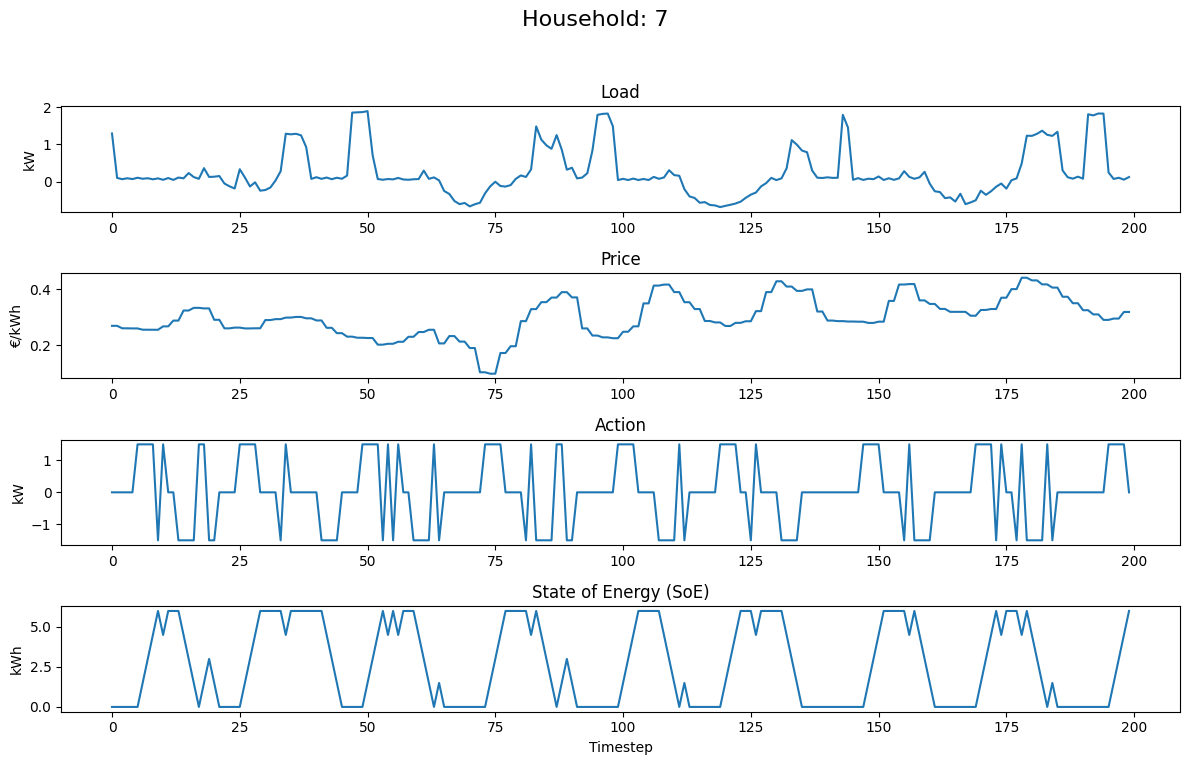

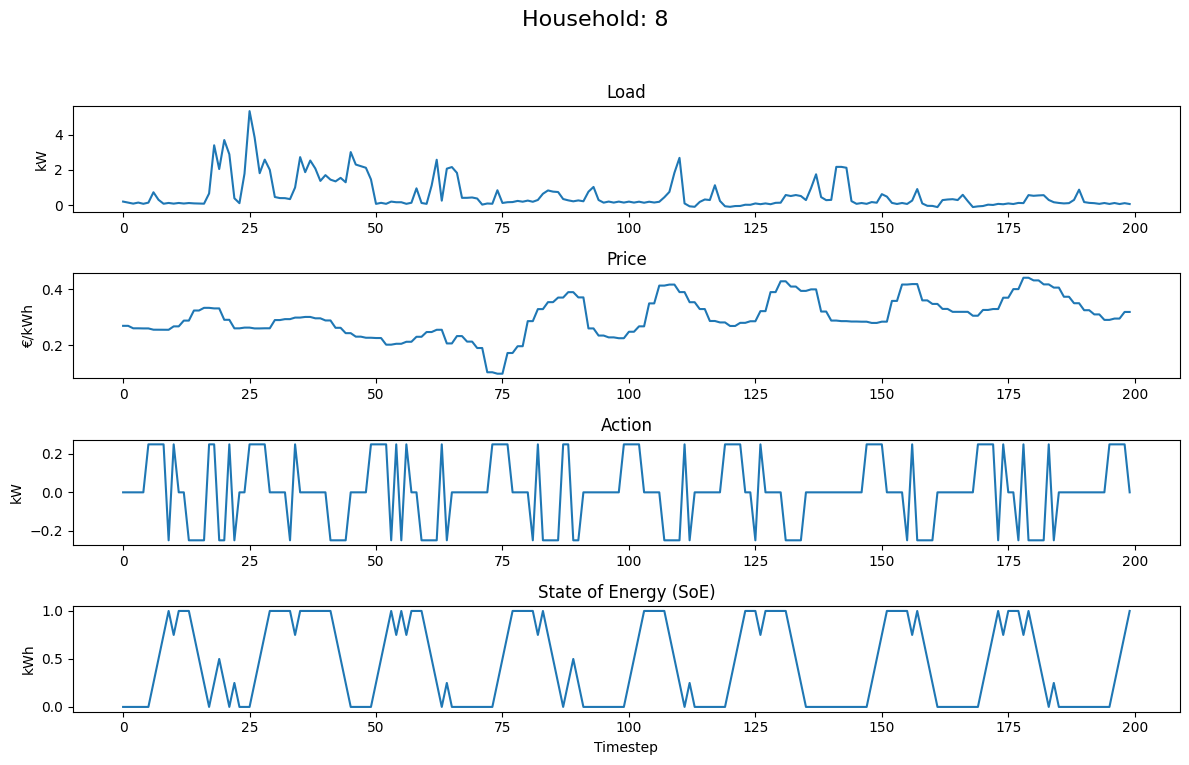

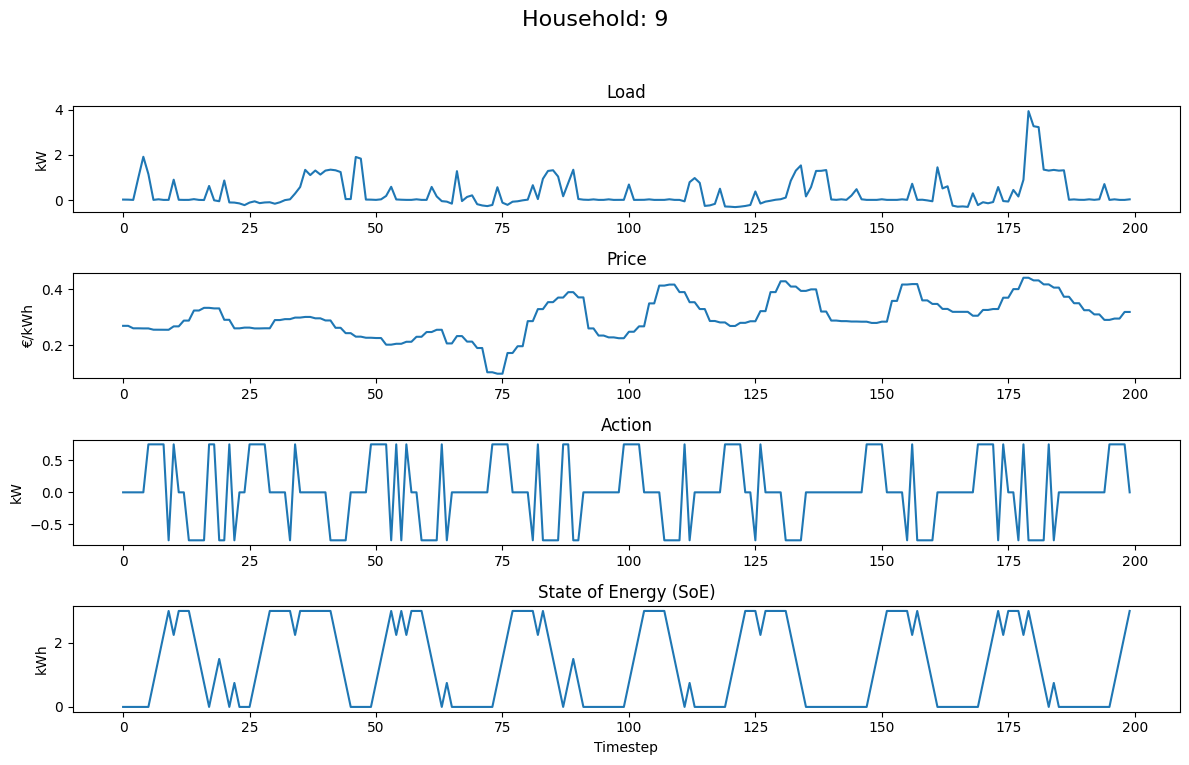

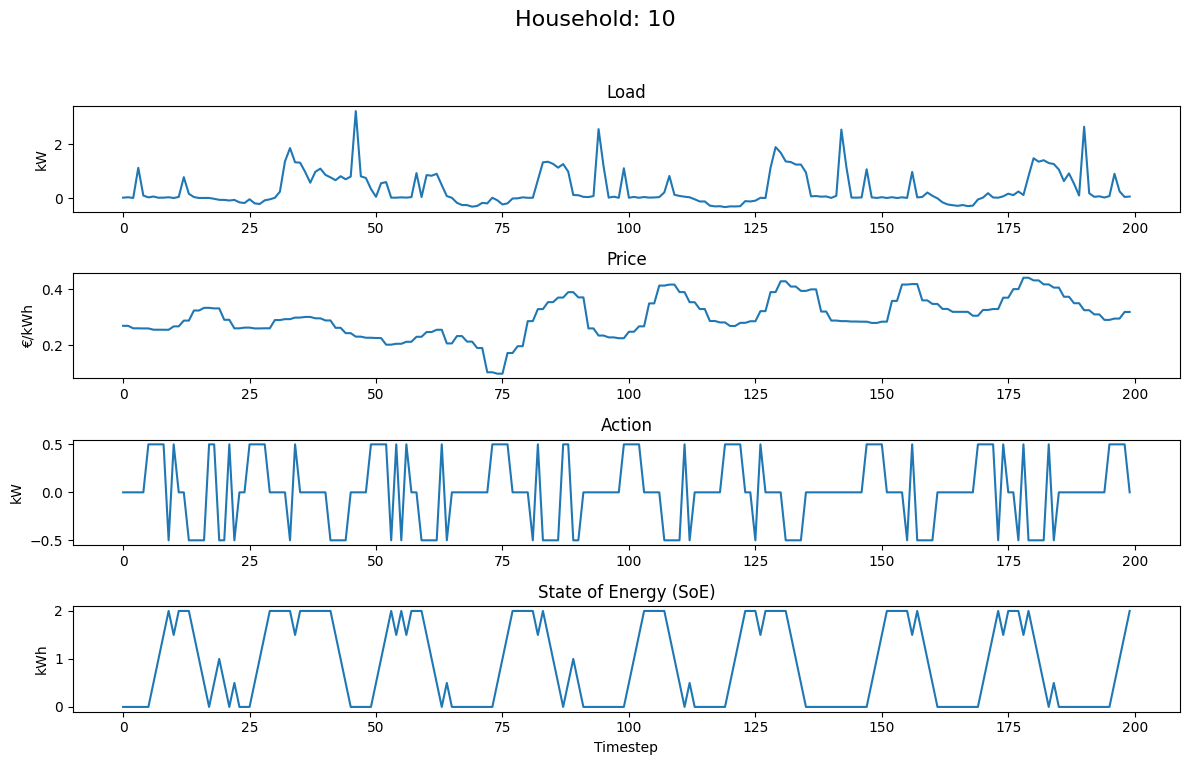

In [90]:
for household in households:
    ds = EnergyDataset('../data/Final_Energy_dataset.csv','../data/price.csv', 48, household, 'test', False)
    load = ds.getAllLoad()[:200]   # tensor
    price = ds.getAllPrice()[:200] # tensor
    type = 'forecast'

    # Load predicted actions and state of energy (soe)
    df = pd.read_csv(f"{output_dir}{filename}_{type}_{household}.csv")
    action = df['actions'][:200]
    soe = df['soe'][:200]

    # Create figure
    plt.figure(figsize=(12, 8))
    plt.suptitle(f'Household: {household}', fontsize=16)

    # Load
    plt.subplot(4, 1, 1)
    plt.plot(load)
    plt.title('Load')
    plt.ylabel('kW')

    # Price
    plt.subplot(4, 1, 2)
    plt.plot(price)
    plt.title('Price')
    plt.ylabel('€/kWh')

    # Action
    plt.subplot(4, 1, 3)
    plt.plot(action)
    plt.title('Action')
    plt.ylabel('kW')

    # State of Energy (SoE)
    plt.subplot(4, 1, 4)
    plt.plot(soe)
    plt.title('State of Energy (SoE)')
    plt.ylabel('kWh')
    plt.xlabel('Timestep')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Make space for suptitle
    plt.show()